In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

import seaborn as sb

import warnings
warnings.filterwarnings('ignore')

In [203]:
DATA_PATH = "/home/stefan/Documents/Workspace/Python/ML/Hackathon/eco-forecast/data"
FILE_NAME = "raw_data.csv"

REGION_CODES = [name for name in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, name))]

FILE_PATH = f'{DATA_PATH}/{FILE_NAME}'

#### Load data and inspect it

In [204]:
df = pd.read_csv(FILE_PATH)

In [205]:
df.head()

,Unnamed: 0,StartTime,green_energy_SE,SE_Load,green_energy_DE,DE_Load,green_energy_HU,HU_Load,green_energy_IT,IT_Load,green_energy_SP,SP_Load,green_energy_NE,NE_Load,green_energy_PO,PO_Load,green_energy_UK,UK_Load,green_energy_DK,DK_Load
0,0,2021-12-31 23:00:00,11060.0,15331,NaN,NaN,NaN,NaN,NaN,21121,NaN,NaN,NaN,NaN,4641,14438,NaN,NaN,3652.0,3314
1,1,2022-01-01 00:00:00,11107.0,15331,145157.0,165125.0,1376.0,16457.0,NaN,19756,NaN,NaN,12708.0,40706.0,4491,13935,NaN,1244.0,3605.0,3218
2,2,2022-01-01 01:00:00,11036.0,15270,138401.0,160415.0,1526.0,15426.0,NaN,18685,NaN,NaN,11097.0,39465.0,4436,13579,NaN,1131.0,3309.0,3126
3,3,2022-01-01 02:00:00,10509.0,15150,132617.0,158035.0,1560.0,14781.0,NaN,18124,NaN,NaN,11282.0,38923.0,4568,13397,NaN,1091.0,3043.0,3080
4,4,2022-01-01 03:00:00,10770.0,15387,127011.0,157016.0,1287.0,14630.0,NaN,18400,NaN,NaN,11245.0,38211.0,4559,13364,NaN,969.0,2852.0,3044


In [206]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   StartTime        8760 non-null   object 
 1   green_energy_SE  8759 non-null   float64
 2   SE_Load          8760 non-null   int64  
 3   green_energy_DE  8759 non-null   float64
 4   DE_Load          8759 non-null   float64
 5   green_energy_HU  8759 non-null   float64
 6   HU_Load          8759 non-null   float64
 7   green_energy_IT  5258 non-null   float64
 8   IT_Load          8760 non-null   int64  
 9   green_energy_SP  5351 non-null   float64
 10  SP_Load          5351 non-null   float64
 11  green_energy_NE  8759 non-null   float64
 12  NE_Load          8759 non-null   float64
 13  green_energy_PO  8760 non-null   int64  
 14  PO_Load          8760 non-null   int64  
 15  green_energy_UK  8135 non-null   float64
 16  UK_Load          4799 non-null   float64
 17  green_energy_D

Transforming feature 'StartTime' from string to datetime that we can use later if needed

In [208]:
df['StartTime'] = pd.to_datetime(df['StartTime'])

In [159]:
df['StartTime'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 8762 entries, 0 to 8761
Series name: StartTime
Non-Null Count  Dtype         
--------------  -----         
8762 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 68.6 KB


Checking if there are any missing values

In [209]:
print(f"Percentage of data missing: {df.isna().sum().sum() / df.shape[0]}%")

Percentage of data missing: 1.7026255707762556%


In [210]:
df.shape

(8760, 19)

In [213]:
df.isna().sum() / df.shape[0] * 100

StartTime           0.000000
green_energy_SE     0.011416
SE_Load             0.000000
green_energy_DE     0.011416
DE_Load             0.011416
green_energy_HU     0.011416
HU_Load             0.011416
green_energy_IT    39.977169
IT_Load             0.000000
green_energy_SP    38.915525
SP_Load            38.915525
green_energy_NE     0.011416
NE_Load             0.011416
green_energy_PO     0.000000
PO_Load             0.000000
green_energy_UK     7.134703
UK_Load            45.216895
green_energy_DK     0.022831
DK_Load             0.000000
dtype: float64

Checking which features are missing the data

In [214]:
print(df.isna().sum())

StartTime             0
green_energy_SE       1
SE_Load               0
green_energy_DE       1
DE_Load               1
green_energy_HU       1
HU_Load               1
green_energy_IT    3502
IT_Load               0
green_energy_SP    3409
SP_Load            3409
green_energy_NE       1
NE_Load               1
green_energy_PO       0
PO_Load               0
green_energy_UK     625
UK_Load            3961
green_energy_DK       2
DK_Load               0
dtype: int64


Due to already dealing with majority of missing data during data_ingestion, we've only got a few missing values (most likely appearing after merging the data)

We'll just impute the missing data with mean values of preceeding and following samples relative to the missing data point

In [221]:
df_nonan = df.copy(deep=True)

In [220]:
df_nonan.dropna(axis=0, inplace=True)

In [218]:
df_nonan.shape[0] * 0.2

259.40000000000003

In [162]:
df.interpolate(method='linear', limit_direction='both', inplace=True)

We could use .describe() to learn more about our data by checking it mean, std, min, max etc. values

We can see that the green energy values differ by quite a bit from region to region which could imply that we'd want to normalize our data prior to feeding it to the model.

There are few regions where there's quite a difference between the minimum and maximum values, we'll have to further analyse those samples.

In [163]:
df.describe()

,StartTime,green_energy_SE,SE_Load,green_energy_DE,DE_Load,green_energy_HU,HU_Load,green_energy_IT,IT_Load,green_energy_SP,SP_Load,green_energy_NE,NE_Load,green_energy_PO,PO_Load,green_energy_UK,UK_Load,green_energy_DK,DK_Load
count,8762,8762.000000,8762.000000,8762.000000,8762.000000,8762.000000,8762.000000,8762.000000,8762.000000,8762.000000,8762.000000,8762.000000,8762.000000,8762.000000,8762.000000,8762.000000,8762.000000,8762.000000,8762.000000
mean,2022-07-02 11:30:00,11788.724835,15081.597466,111622.346953,220366.056494,2302.050445,19824.494408,9552.855056,32673.536635,55995.024195,107795.684090,7036.460055,45837.215362,3709.669254,19678.098722,1143.480256,1660.541201,2875.783326,3918.788861
min,2021-12-31 23:00:00,6116.000000,9013.000000,27675.000000,137905.000000,297.000000,12893.000000,2562.000000,16599.000000,11304.000000,64452.000000,90.000000,21592.000000,255.000000,11824.000000,0.000000,860.000000,143.000000,2233.000000
25%,2022-04-02 05:15:00,10460.250000,12548.000000,70077.750000,188997.250000,833.000000,17639.250000,6176.500000,26494.500000,39912.750000,93780.875000,2500.500000,40567.000000,2066.000000,17018.000000,866.000000,1594.000000,1661.000000,3392.000000
50%,2022-07-02 11:30:00,11555.500000,14539.000000,107327.000000,220397.000000,1281.000000,19739.000000,8950.500000,32176.500000,54492.000000,108782.000000,5509.500000,44858.000000,3383.000000,19845.000000,1303.175167,1594.000000,2653.000000,3893.000000
75%,2022-10-01 17:45:00,12970.750000,17441.750000,147750.750000,250076.500000,3355.750000,21843.000000,12501.500000,38344.250000,70525.125000,120763.500000,11026.500000,50968.000000,5103.000000,21998.000000,1492.758350,1777.000000,3970.750000,4420.000000
max,2023-01-01 00:00:00,19221.000000,24250.000000,260426.000000,314883.000000,8417.000000,28194.000000,22842.000000,51761.000000,126194.000000,151328.000000,19159.000000,70641.000000,11292.000000,27211.000000,2060.000000,2979.000000,6970.000000,5834.000000
std,NaN,1807.726944,3117.847984,48843.951694,38312.283865,2031.863706,2986.893468,4084.799573,7238.284516,20473.372273,16977.195529,5230.180150,7888.118915,2030.837029,3165.880762,472.001518,325.184264,1478.070761,703.088407


Adding columns for day, hour, month so we can use them for plotting

In [72]:
df['day'] = df['StartTime'].dt.day
df['month'] = df['StartTime'].dt.month
df['hour'] = df['StartTime'].dt.hour

#### Plots

Plotting a correlation matrix to check if there's any correlation between the day or month with green energy values or load values

In [73]:
corrMatrix = df.corr().round(2)

There seems to be some correlation between green energy/load values with hourly information, further on we'll check this using different plots

<Axes: >

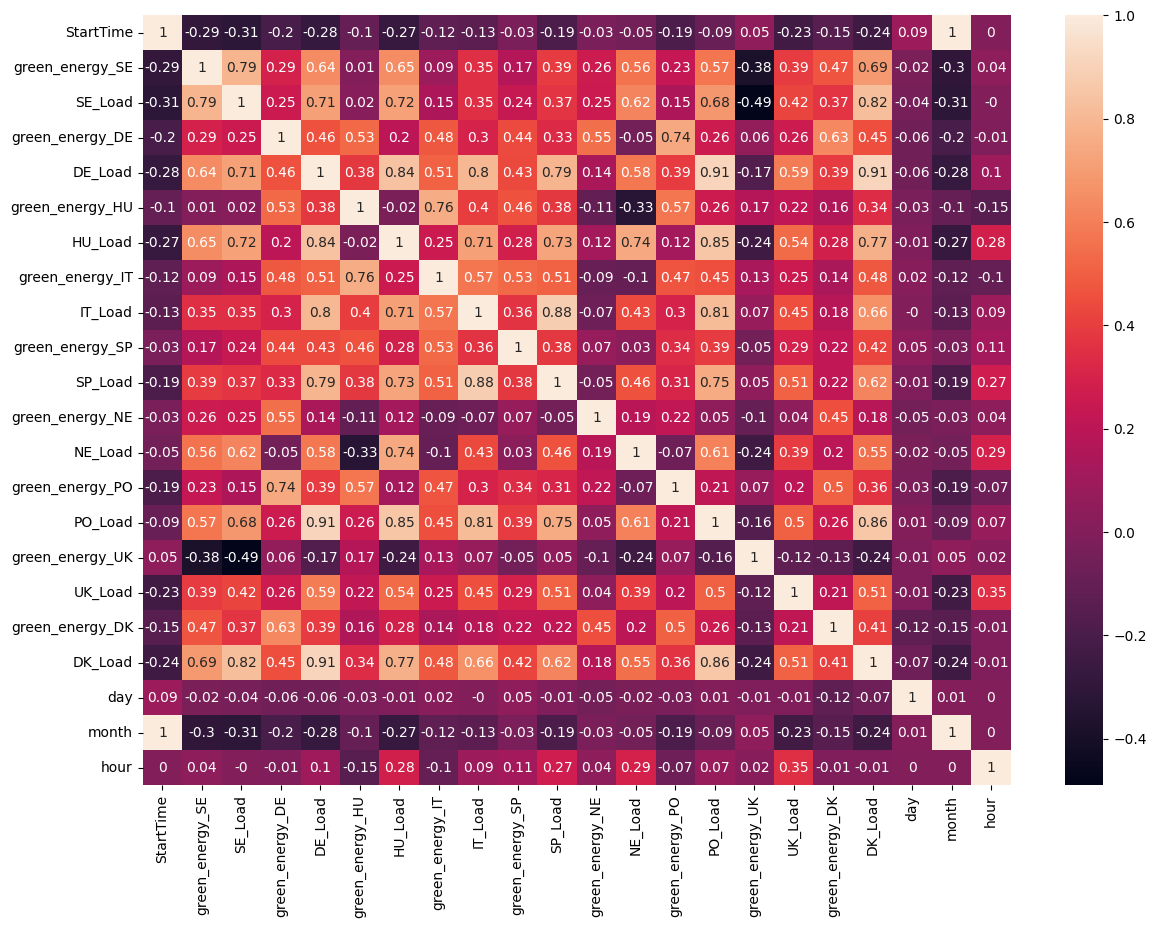

In [74]:
plt.figure(figsize=(14, 10))
sb.heatmap(corrMatrix, annot=True)

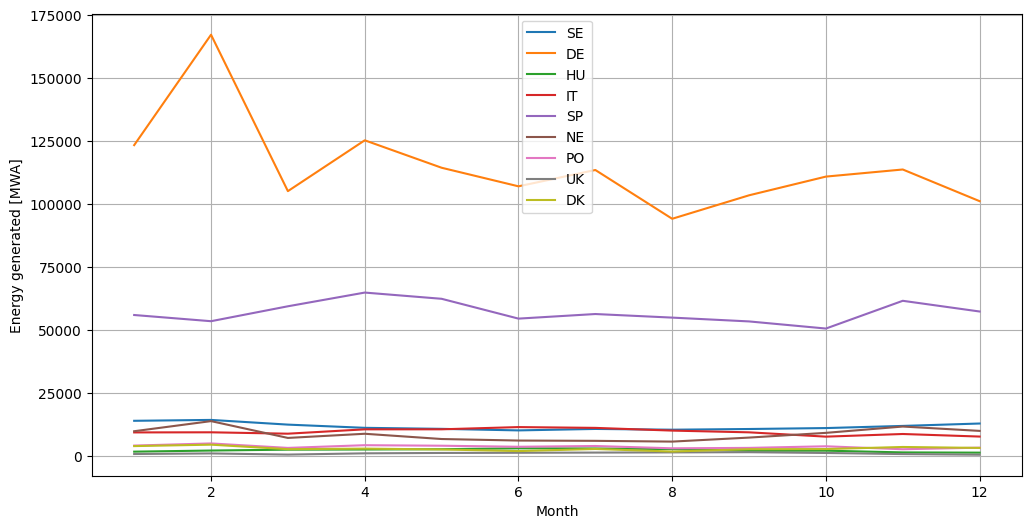

In [78]:
plt.figure(figsize=(12, 6))
for reg in REGION_CODES:
    if f'green_energy_{reg}' not in list(df.columns):
        continue
    df.groupby(['month'])[f'green_energy_{reg}'].mean().plot(label=reg, legend=True)
    # df.groupby(['hour'])['green_energy_SE'].mean().plot(label='SE', legend=True)
    # df.groupby(['hour'])['green_energy_DE'].mean().plot(label='DE', legend=True)
    # df.groupby(['hour'])['green_energy_HU'].mean().plot(label='HU', legend=True)
plt.grid()
plt.xlabel('Month')
plt.ylabel('Energy generated [MWA]')
plt.show()

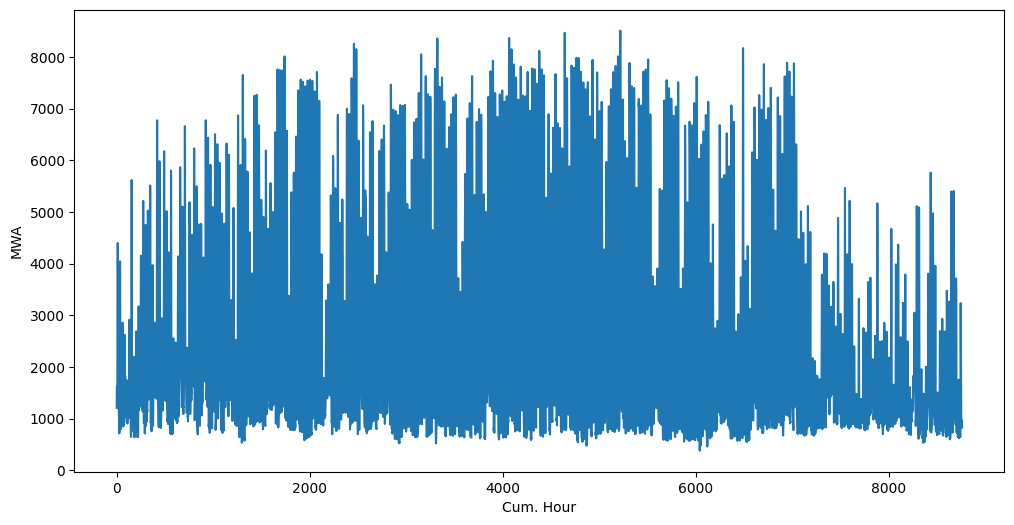

In [79]:
plt.figure(figsize=(12, 6))
plt.plot(df['green_energy_HU'])
plt.xlabel('Cum. Hour')
plt.ylabel('MWA')
plt.show()

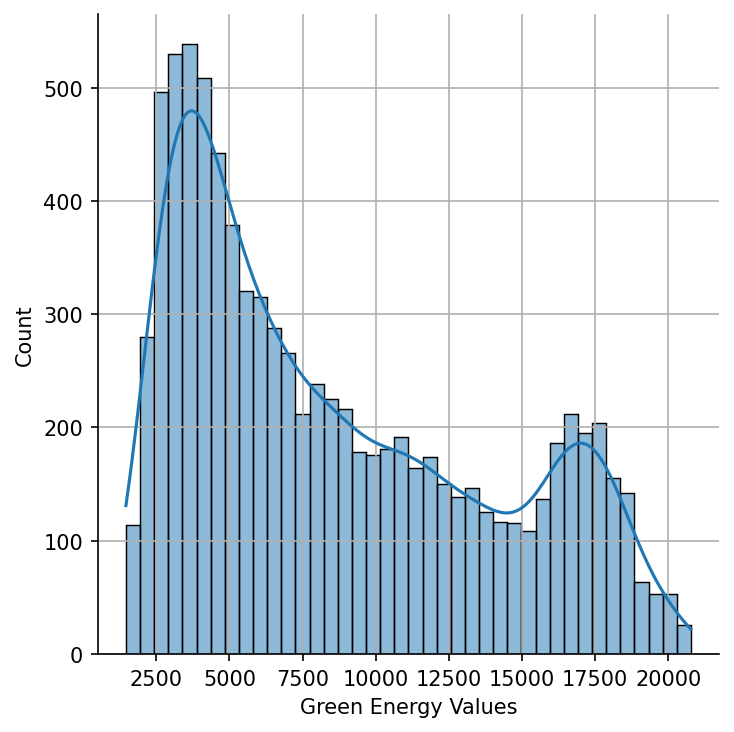

In [80]:
p = sb.displot(df['green_energy_NE'], bins=40, kde=True, rug=False)
plt.grid()
plt.xlabel(xlabel='Green Energy Values')
p.fig.set_dpi(150)
plt.show()


#### TEST AREA

In [20]:
def identify_outliers(data):

    # q1 q3 percentiles
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)

    IQR = Q3 - Q1

    # lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = (data < lower_bound) | (data > upper_bound)

    return outliers

In [38]:
df = pd.read_csv(FILE_PATH)
df['StartTime'] = pd.to_datetime(df['StartTime'])

In [49]:
if df.isna().sum().sum() > 0:
    df.interpolate(method='linear', limit_direction='both', inplace=True)


In [57]:
if df.isna().sum().sum() > 0:
    df.interpolate(method='linear', limit_direction='both', inplace=True)

    # Imputing outliers with mean value
for col in df.columns:
    outliers = identify_outliers(df[col])
    if sum(outliers) == 0:
        continue
    print(f"{col}: Num of outliers: {sum(outliers)}")
    print(df.loc[outliers, col])
    print(df.loc[:, col].describe())
    df.loc[outliers, col] = df[col].mean()
    print()

In [42]:
df['green_energy_'].describe()

count       98.000000
mean     12342.841837
std       1550.412948
min       7898.000000
25%      11448.250000
50%      12668.000000
75%      13495.750000
max      14840.000000
Name: green_energy_SE, dtype: float64

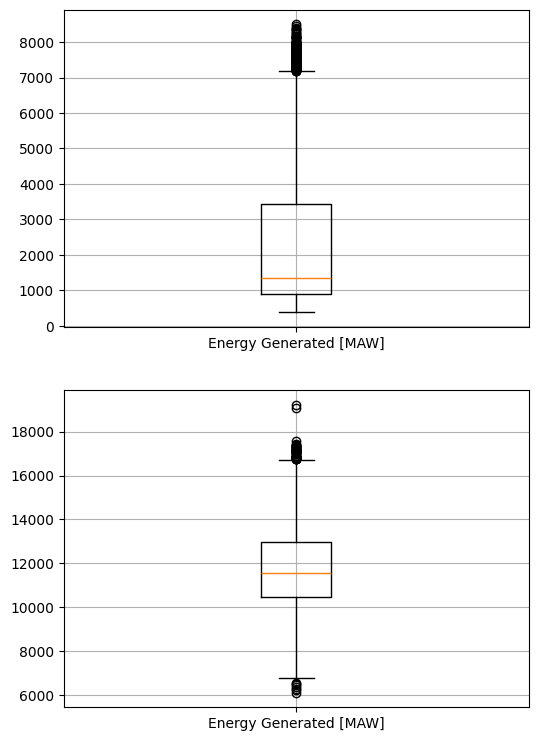

In [81]:
"""
    green_energy_SE
    green_energy_HU
"""

plt.figure(figsize=(6, 14))
plt.subplot(3, 1, 1)
plt.boxplot([df['green_energy_HU']])
plt.xticks([1], ["Energy Generated [MAW]"])
plt.grid()

plt.subplot(3, 1, 2)
plt.boxplot([df['green_energy_SE']])
plt.xticks([1], ["Energy Generated [MAW]"])
plt.grid()

# plt.subplot(3, 1, 3)
# plt.boxplot([df['green_energy_IT']])
# plt.xticks([1], ["Energy Generated [MAW]"])
# plt.grid()

#### Adding Label

In [82]:
df.head()

,StartTime,green_energy_SE,SE_Load,green_energy_DE,DE_Load,green_energy_HU,HU_Load,green_energy_IT,IT_Load,green_energy_SP,...,NE_Load,green_energy_PO,PO_Load,green_energy_UK,UK_Load,green_energy_DK,DK_Load,day,month,hour
0,2021-12-31 23:00:00,11061.0,15331.0,151608.0,168784.0,1208.0,17016.0,5704.666667,21121.0,45418.0,...,41304.0,4734.0,14438.0,866.0,1354.0,3821.0,3314.0,31,12,23
1,2022-01-01 00:00:00,11108.0,15331.0,148520.0,165125.0,1441.0,16457.0,5704.666667,19756.0,44839.0,...,40706.0,4584.0,13935.0,866.0,1244.0,3774.0,3218.0,1,1,0
2,2022-01-01 01:00:00,11037.0,15270.0,141730.0,160415.0,1592.0,15426.0,5628.333333,18685.0,45946.5,...,39465.0,4529.0,13579.0,866.0,1131.0,3478.0,3126.0,1,1,1
3,2022-01-01 02:00:00,10510.0,15150.0,135947.0,158035.0,1624.0,14781.0,5781.000000,18124.0,46322.0,...,38923.0,4661.0,13397.0,866.0,1091.0,3212.0,3080.0,1,1,2
4,2022-01-01 03:00:00,10771.0,15387.0,130309.0,157016.0,1352.0,14630.0,5546.666667,18400.0,45486.5,...,38211.0,4652.0,13364.0,866.0,969.0,3021.0,3044.0,1,1,3


In [137]:
df = df_standardized.copy(deep=True)

In [164]:
countries = [col.split('_')[2] for col in df.columns if 'green_energy' in col]

In [165]:
countries

['SE', 'DE', 'HU', 'IT', 'SP', 'NE', 'PO', 'UK', 'DK']

In [166]:
# Calculate surplus for each country
for country in countries:
    df[f'surplus_{country}'] = np.abs(df[f'green_energy_{country}'] - df[f'{country}_Load'])

In [167]:
df.head()

,StartTime,green_energy_SE,SE_Load,green_energy_DE,DE_Load,green_energy_HU,HU_Load,green_energy_IT,IT_Load,green_energy_SP,...,DK_Load,surplus_SE,surplus_DE,surplus_HU,surplus_IT,surplus_SP,surplus_NE,surplus_PO,surplus_UK,surplus_DK
0,2021-12-31 23:00:00,11060.0,15331.0,148216.0,168784.0,1140.0,17016.0,5614.0,21121.0,44350.5,...,3314.0,4271.0,20568.0,15876.0,15507.0,37012.0,27164.0,9797.0,488.0,338.0
1,2022-01-01 00:00:00,11107.0,15331.0,145157.0,165125.0,1376.0,16457.0,5614.0,19756.0,43777.5,...,3218.0,4224.0,19968.0,15081.0,14142.0,32622.0,27998.0,9444.0,378.0,387.0
2,2022-01-01 01:00:00,11036.0,15270.0,138401.0,160415.0,1526.0,15426.0,5528.0,18685.0,44891.5,...,3126.0,4234.0,22014.0,13900.0,13157.0,27586.0,28368.0,9143.0,265.0,183.0
3,2022-01-01 02:00:00,10509.0,15150.0,132617.0,158035.0,1560.0,14781.0,5672.0,18124.0,45273.0,...,3080.0,4641.0,25418.0,13221.0,12452.0,25021.0,27641.0,8829.0,225.0,37.0
4,2022-01-01 03:00:00,10770.0,15387.0,127011.0,157016.0,1287.0,14630.0,5426.0,18400.0,44419.5,...,3044.0,4617.0,30005.0,13343.0,12974.0,25386.5,26966.0,8805.0,103.0,192.0


In [168]:
# Find the country with the maximum surplus for each sample
df['max_surplus_country'] = df.apply(lambda row: countries[row[[f'surplus_{country}' for country in countries]].values.argmax()], axis=1)

# Print or use df as needed
print(df[['max_surplus_country']])

     max_surplus_country
0                     SP
1                     SP
2                     NE
3                     NE
4                     DE
...                  ...
8757                  SP
8758                  SP
8759                  SP
8760                  SP
8761                  SP

[8762 rows x 1 columns]


In [103]:
df.loc[:0, ['green_energy_SP', 'SP_Load', 'surplus_SP']]

,green_energy_SP,SP_Load,surplus_SP
0,45418.0,81362.5,35944.5


DE    7651
SP     941
NE     155
IT      15

DE    7724
SP     869
NE     157
IT      12

In [171]:
df['max_surplus_country'].value_counts()
df['label'] = df['max_surplus_country']

In [173]:
region_code_dict = {
    "SP": 0,
    "UK": 1,
    "DE": 2,
    "DK": 3,
    "SE": 4,
    "HU": 5,
    "IT": 6,
    "PO": 7,
    "NE": 8
}

In [175]:
df['label'].replace(region_code_dict, inplace=True)

In [176]:
df['label'].value_counts()

label
2    7724
0     869
8     157
6      12
Name: count, dtype: int64

#### Normalizing data

In [115]:
df.columns

Index(['StartTime', 'green_energy_SE', 'SE_Load', 'green_energy_DE', 'DE_Load',
       'green_energy_HU', 'HU_Load', 'green_energy_IT', 'IT_Load',
       'green_energy_SP', 'SP_Load', 'green_energy_NE', 'NE_Load',
       'green_energy_PO', 'PO_Load', 'green_energy_UK', 'UK_Load',
       'green_energy_DK', 'DK_Load'],
      dtype='object')

In [116]:
x = df.drop(['StartTime'], axis=1)

In [130]:
x

,green_energy_SE,SE_Load,green_energy_DE,DE_Load,green_energy_HU,HU_Load,green_energy_IT,IT_Load,green_energy_SP,SP_Load,green_energy_NE,NE_Load,green_energy_PO,PO_Load,green_energy_UK,UK_Load,green_energy_DK,DK_Load
0,11061.0,15331.0,151608.0,168784.0,1208.0,17016.0,5704.666667,21121.0,45418.0,81362.5,15788.0,41304.0,4734.0,14438.0,866.0,1354.0,3821.0,3314.0
1,11108.0,15331.0,148520.0,165125.0,1441.0,16457.0,5704.666667,19756.0,44839.0,76399.5,14335.0,40706.0,4584.0,13935.0,866.0,1244.0,3774.0,3218.0
2,11037.0,15270.0,141730.0,160415.0,1592.0,15426.0,5628.333333,18685.0,45946.5,72477.5,12747.0,39465.0,4529.0,13579.0,866.0,1131.0,3478.0,3126.0
3,10510.0,15150.0,135947.0,158035.0,1624.0,14781.0,5781.000000,18124.0,46322.0,70294.0,12919.0,38923.0,4661.0,13397.0,866.0,1091.0,3212.0,3080.0
4,10771.0,15387.0,130309.0,157016.0,1352.0,14630.0,5546.666667,18400.0,45486.5,69806.0,12901.0,38211.0,4652.0,13364.0,866.0,969.0,3021.0,3044.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8757,9587.0,14201.0,166297.0,175401.0,969.0,17075.0,3890.000000,23169.0,60288.0,97124.0,18872.0,43425.0,7063.0,14641.0,415.0,1646.0,1737.0,3579.0
8758,9149.0,13713.0,164040.0,168830.0,889.0,16717.0,3754.000000,21857.0,55200.0,87316.0,18729.0,41766.0,7207.0,13977.0,338.0,1646.0,1927.0,3520.0
8759,8807.0,13772.0,155575.0,161541.0,825.0,16261.0,3694.000000,20555.0,46924.0,82064.0,17503.0,40415.0,6099.0,13272.0,245.0,1646.0,2369.0,3440.0
8760,8807.0,13772.0,153600.0,153523.0,841.0,15641.0,3694.000000,20555.0,39148.0,79740.0,13760.0,39412.0,6099.0,13272.0,150.0,1646.0,2369.0,3440.0


In [131]:
from sklearn.preprocessing import StandardScaler

# Assuming your dataframe is named df
scaler = StandardScaler()


df_standardized = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

In [132]:
df_standardized

,green_energy_SE,SE_Load,green_energy_DE,DE_Load,green_energy_HU,HU_Load,green_energy_IT,IT_Load,green_energy_SP,SP_Load,green_energy_NE,NE_Load,green_energy_PO,PO_Load,green_energy_UK,UK_Load,green_energy_DK,DK_Load
0,-0.403513,0.079996,0.758339,-1.346435,-0.573845,-0.940326,-0.978314,-1.596123,-0.573745,-1.557071,1.389246,-0.574722,0.468215,-1.655273,-0.587915,-1.027102,0.537612,-0.860238
1,-0.377514,0.079996,0.695124,-1.441945,-0.458853,-1.127488,-0.978314,-1.784715,-0.602083,-1.849421,1.109376,-0.650536,0.394421,-1.814164,-0.587915,-1.369398,0.505818,-0.996786
2,-0.416789,0.060431,0.556124,-1.564889,-0.384331,-1.472682,-0.997172,-1.932687,-0.547879,-2.080450,0.803502,-0.807871,0.367363,-1.926619,-0.587915,-1.721029,0.305581,-1.127645
3,-0.708314,0.021940,0.437739,-1.627014,-0.368538,-1.688638,-0.959456,-2.010196,-0.529501,-2.209071,0.836632,-0.876585,0.432302,-1.984110,-0.587915,-1.845501,0.125638,-1.193074
4,-0.563935,0.097959,0.322323,-1.653613,-0.502777,-1.739195,-1.017347,-1.972063,-0.570393,-2.237817,0.833165,-0.966853,0.427874,-1.994535,-0.587915,-2.225138,-0.003569,-1.244280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8757,-1.218898,-0.282454,1.059040,-1.173713,-0.691798,-0.920572,-1.426625,-1.313167,0.154040,-0.628625,1.983271,-0.305821,1.613986,-1.591148,-1.543477,-0.118461,-0.872166,-0.483308
8758,-1.461190,-0.438981,1.012837,-1.345234,-0.731280,-1.040436,-1.460224,-1.494436,-0.094983,-1.206374,1.955727,-0.516149,1.684828,-1.800897,-1.706622,-0.118461,-0.743635,-0.567228
8759,-1.650377,-0.420056,0.839548,-1.535497,-0.762866,-1.193112,-1.475047,-1.674323,-0.500037,-1.515748,1.719581,-0.687429,1.139738,-2.023596,-1.903666,-0.118461,-0.444633,-0.681018
8760,-1.650377,-0.420056,0.799117,-1.744790,-0.754969,-1.400697,-1.475047,-1.674323,-0.880619,-1.652645,0.998622,-0.814590,1.139738,-2.023596,-2.104949,-0.118461,-0.444633,-0.681018


In [186]:
dic = dict(df['label'].value_counts())
max(dic, key=dic.get)

2

In [187]:
dic

{2: 7724, 0: 869, 8: 157, 6: 12}

In [188]:
df.head()

,StartTime,green_energy_SE,SE_Load,green_energy_DE,DE_Load,green_energy_HU,HU_Load,green_energy_IT,IT_Load,green_energy_SP,...,surplus_DE,surplus_HU,surplus_IT,surplus_SP,surplus_NE,surplus_PO,surplus_UK,surplus_DK,max_surplus_country,label
0,2021-12-31 23:00:00,11060.0,15331.0,148216.0,168784.0,1140.0,17016.0,5614.0,21121.0,44350.5,...,20568.0,15876.0,15507.0,37012.0,27164.0,9797.0,488.0,338.0,SP,0
1,2022-01-01 00:00:00,11107.0,15331.0,145157.0,165125.0,1376.0,16457.0,5614.0,19756.0,43777.5,...,19968.0,15081.0,14142.0,32622.0,27998.0,9444.0,378.0,387.0,SP,0
2,2022-01-01 01:00:00,11036.0,15270.0,138401.0,160415.0,1526.0,15426.0,5528.0,18685.0,44891.5,...,22014.0,13900.0,13157.0,27586.0,28368.0,9143.0,265.0,183.0,NE,8
3,2022-01-01 02:00:00,10509.0,15150.0,132617.0,158035.0,1560.0,14781.0,5672.0,18124.0,45273.0,...,25418.0,13221.0,12452.0,25021.0,27641.0,8829.0,225.0,37.0,NE,8
4,2022-01-01 03:00:00,10770.0,15387.0,127011.0,157016.0,1287.0,14630.0,5426.0,18400.0,44419.5,...,30005.0,13343.0,12974.0,25386.5,26966.0,8805.0,103.0,192.0,DE,2


In [191]:
df.to_csv(f'{DATA_PATH}/train.csv')